### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

### Integrantes:
* Eduardo Hopperdietzel
* Diego Sandoval

# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

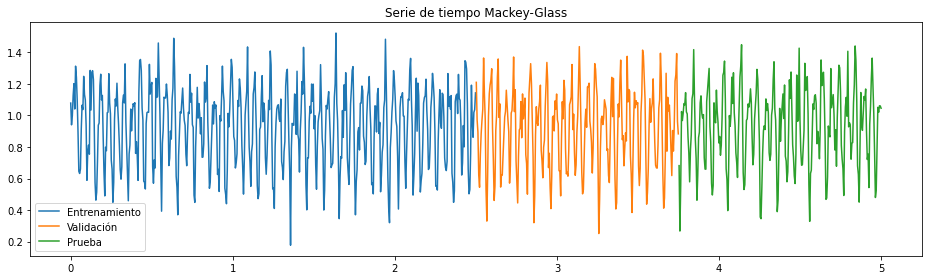

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
fig, ax = plt.subplots(figsize=(13, 4), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**

El algorimto LMS se utiliza en algunos tipos de filtros adaptivos, donde su objetivo es en encontrar los coeficientes de un filtro FIR que, al convolucionarlos con una señal, minimicen el error cuadrático medio entre esta y su valor esperado ( sin ruido o modelado ).
Este reajuste de los coeficientes se realiza de manera online, cada vez que llegan nuevos datos, se aplica el filtrado a la señal de entrada, se calcula el error respecto a la señal deseada y luego se adaptan los coeficientes regulando el cambio por una variable mu (0-1).

Usaremos la implementación de LMS demostrada en clases:

In [15]:
class Filtro_NLMS:

    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(L)
        self.mu = mu
        self.delta = delta

    def update(self, un, dn):
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn


2. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.

Creamos una función que permite encontrar el mu y L que minimizan el NMSE en el conjunto de validación. La función también almacena el NMSE obtenido en cada iteración tanto en el conjunto de entrenamiento como en el de validación para su posterior análisis visual. Al calcular los NMSE no se toman en cuenta los primeros L 
valores de la señal deseada ni de la predicha ( ya que se comienza a predecir desde ese punto ).

In [16]:
# Retorna mejor mu y L
def BestNLMS():
    
    # Iteraciones totales
    iters = len(filter_lengths) * len(mus)
    
    # Contador
    i = 0
    
    # Deja registro de los NMSE en entrenamiento
    train_errs = np.zeros(iters)
    
    # Deja registro de los NMSE en validación
    valid_errs = np.zeros(iters)
    
    # Almacena el menor NMSE encontrado en entrenamiento
    min_train_nmse = 1e20 
    
    # Almacena el menor NMSE encontrado en validación
    min_valid_nmse = 1e20 
    
    # Almacena el mejor largo del filtro
    best_L = 1
    
    # Almacena el mejor mu
    best_mu = 0
    
    # Almacena predicciones que se harán en el conjunto de entrenamiento
    train_y_hat = np.zeros(len(y_train)) 
    
    # Almacena predicciones que se harán en el conjunto validación
    valid_y_hat = np.zeros(len(y_valid)) 

    # Loop por cada largo de filtro
    for L in filter_lengths:
        
        # Loop por cada mu
        for mu in mus:

            # Crea el filtros NLMS
            nlms = Filtro_NLMS(L=L, mu=mu)
            
            # Prueba en el conjunto de entrenamiento
            for k in range(L, len(y_train)-1):
                train_y_hat[k] = nlms.update(y_train[k-L:k], y_train[k+1])
            
            # Reinicia los coeficientes del filtro
            nlms.w = np.zeros(L)
            
            # Prueba en el conjunto de validación
            for k in range(L, len(y_valid)-1):
                valid_y_hat[k] = nlms.update(y_valid[k-L:k], y_valid[k+1])
                
            # Calcula el NLMS con predicciones de entrenamiento
            train_errs[i] = NMSE(y_train[L-1:-1],train_y_hat[L-1:-1])
            
            # Calcula el NLMS con predicciones de validación
            valid_errs[i] = NMSE(y_valid[L-1:-1],valid_y_hat[L-1:-1])
            
            # Si es mejor
            if valid_errs[i] <= min_valid_nmse: #and train_errs[i] <= min_train_nmse:
                
                # Reemplaza el menor NMSE
                min_train_nmse = train_errs[i]
                min_valid_nmse = valid_errs[i]
                
                # Guarda los coeficientes
                best_L = L
                best_mu = mu
            
            # Aumenta el contador
            i = i + 1
                
    # Retorna el mejor filtro encontrado
    return best_L,best_mu,train_errs,valid_errs;


## Exploración de L ( tau = 17 )
Generamos el dataset con tau 17, creamos un arreglo de valores a testear para L desde 2 a 60 y para mu un barrido logarítmico de 10 intervalos.
El objetivo es encontrar el mejor L.

In [20]:
# Configuración para entrenamiento y validación

# Crea serie de tiempo con tau 17
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
t_test17 = t_test
y_test17 = y_test

# Largos de filtro a probar
filter_lengths = np.arange(2,60)

# Parámetros mu a probar
mus =  np.logspace(-2, 0, num=10)

Realizamos exploración del mejor L ( tarda unos segundos ).

In [21]:
# Barrido explorador
best_L,best_mu,train_errs,valid_errs = BestNLMS()
print("Mejor L:",best_L)
print("Mejor mu:",best_mu)

Mejor L: 51
Mejor mu: 0.5994842503189409


Obtenemos que el mejor L podría ser 51, sin embargo, a continuación, al graficar el NMSE de cada iteración podemos ver que no se obtienen mejoras considerables con valores para L mayores a 12.

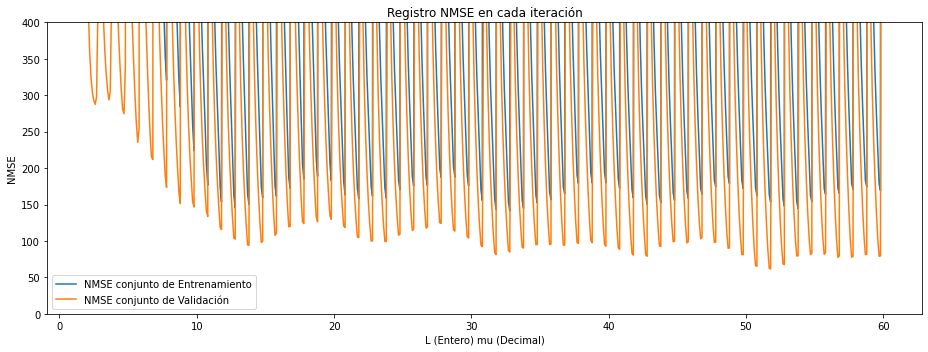

In [6]:
# Gráfica de errores 
fig, ax = plt.subplots(figsize=(13, 5), tight_layout=True)
x = np.arange(2,60,0.1)
ax.plot(x,train_errs, label='NMSE conjunto de Entrenamiento')
ax.plot(x,valid_errs, label='NMSE conjunto de Validación')
ax.set_title('Registro NMSE en cada iteración');
ax.set_ylabel('NMSE');
ax.set_xlabel('L (Entero) mu (Decimal)');
ax.set_ylim([0,400])
ax.legend();

*Cada valle representa el transcurso de explotación de mu de cada L ( Los números enteros corresponden a los comienzos de cada L, y los decimales el transcurso de los mu)*

## Exploración de mu ( tau = 17 )
Ya que el mejor L encontrado es 51 procederemos a buscar el mejor mu, para esto realizaremos nuevamente un barrido logarítmico pero con 1000 intervalos. ( Tarda unos segundos )

Mejor L: 51
Mejor mu: 0.48493740673352353


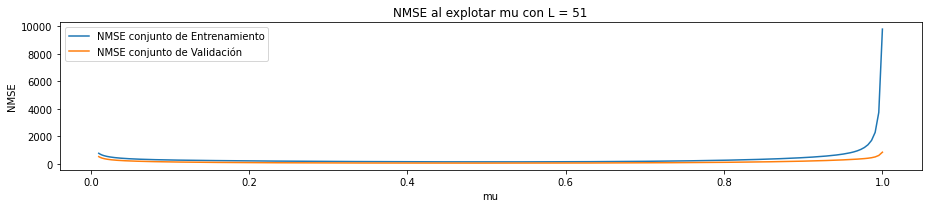

In [7]:
# Barrido explotador

# Largos de filtro a probar
filter_lengths = [51]

# Parámetros mu a probar
mus =  np.logspace(-2, 0, num=1000)

best_L,best_mu,train_errs,valid_errs = BestNLMS()
print("Mejor L:",best_L)
print("Mejor mu:",best_mu)

# Gráfica de errores 
fig, ax = plt.subplots(figsize=(13, 3), tight_layout=True)

ax.plot(mus,train_errs, label='NMSE conjunto de Entrenamiento')
ax.plot(mus,valid_errs, label='NMSE conjunto de Validación')
ax.set_title('NMSE al explotar mu con L = 51');
ax.set_ylabel('NMSE');
ax.set_xlabel('mu');
ax.legend();

Obtenemos que el mejor mu es 0.48493740673352353.

3. Repita el paso anterior para el caso $\tau = 30$

## Exploración de L ( tau = 30 )
Generamos el dataset con tau 30, creamos el mismo arreglo de valores a testear para L desde 2 a 60 y para mu el mismo barrido logarítmico de 10 intervalos.

In [8]:
# Configuración para entrenamiento y validación

# Crea serie de tiempo con tau 30
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
t_test30 = t_test
y_test30 = y_test

# Largos de filtro a probar
filter_lengths = np.arange(2,60)

# Parámetros mu a probar
mus =  np.logspace(-2, 0, num=10)

Realizamos exploración del mejor L ( tarda unos segundos ).

In [9]:
# Barrido explorador
best_L,best_mu,train_errs,valid_errs = BestNLMS()
print("Mejor L:",best_L)
print("Mejor mu:",best_mu)

Mejor L: 47
Mejor mu: 0.5994842503189409


Obtenemos que el mejor L podría ser 47, sin embargo al igual que con tau=17, al graficar el NMSE de cada iteración podemos ver que no se obtienen mejoras considerables con valores para L mayores a 12.

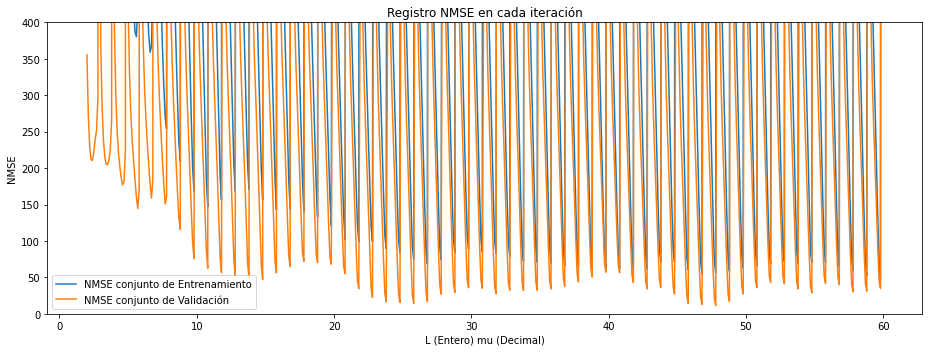

In [10]:
# Gráfica de errores 
fig, ax = plt.subplots(figsize=(13, 5), tight_layout=True)
x = np.arange(2,60,0.1)
ax.plot(x,train_errs, label='NMSE conjunto de Entrenamiento')
ax.plot(x,valid_errs, label='NMSE conjunto de Validación')
ax.set_title('Registro NMSE en cada iteración');
ax.set_ylabel('NMSE');
ax.set_xlabel('L (Entero) mu (Decimal)');
ax.set_ylim([0,400])
ax.legend();

*Cada valle representa el transcurso de explotación de mu de cada L ( Los números enteros corresponden a los comienzos de cada L, y los decimales el transcurso de los mu)*

## Exploración de mu ( tau = 30 )
Ya que el mejor L encontrado es 47 procederemos a buscar el mejor mu, para esto realizaremos nuevamente un barrido logarítmico pero con 1000 intervalos. ( Tarda unos segundos )

Mejor L: 47
Mejor mu: 0.5148867450137495


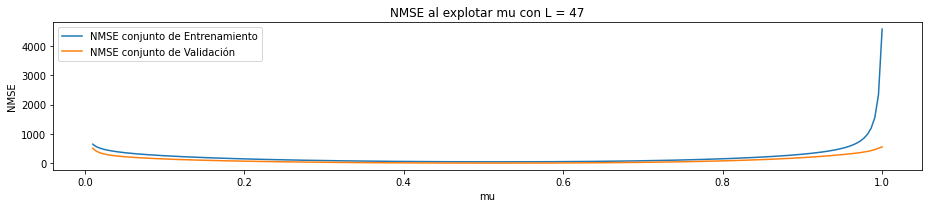

In [11]:
# Barrido explotador

# Largos de filtro a probar
filter_lengths = [47]

# Parámetros mu a probar
mus =  np.logspace(-2, 0, num=1000)

best_L,best_mu,train_errs,valid_errs = BestNLMS()
print("Mejor L:",best_L)
print("Mejor mu:",best_mu)

# Gráfica de errores 
fig, ax = plt.subplots(figsize=(13, 3), tight_layout=True)

ax.plot(mus,train_errs, label='NMSE conjunto de Entrenamiento')
ax.plot(mus,valid_errs, label='NMSE conjunto de Validación')
ax.set_title('NMSE al explotar mu con L = 47');
ax.set_ylabel('NMSE');
ax.set_xlabel('mu');
ax.legend();

4. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## Predicción en conjunto de prueba

NMSE tau 17: 70.66237064651736
NMSE tau 30: 20.848845989962054


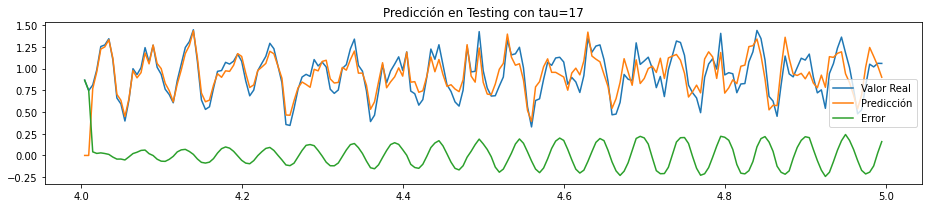

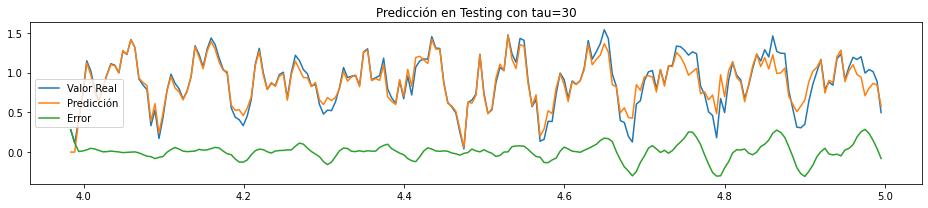

In [12]:
# Creamos filtros con los mejores L y mu encontrados
nlms17 = Filtro_NLMS(L=51, mu=0.48493740673352353)
nlms30 = Filtro_NLMS(L=47, mu=0.5148867450137495)

# Almacena predicciones
pred17 = np.zeros(len(y_test17))
pred30 = np.zeros(len(y_test30))

# Realiza predicciones
for k in range(51, len(y_test17)-1):
    pred17[k] = nlms17.update(y_test17[k-51:k],y_test17[k+1])
    
for k in range(47, len(y_test30)-1):
    pred30[k] = nlms30.update(y_test30[k-47:k],y_test30[k+1])

# Gráfica de conjunto de testing, predicción y error
fig, ax = plt.subplots(figsize=(13, 3), tight_layout=True)
ax.plot(t_test17[51-1:-1], y_test17[51-1:-1], label='Valor Real')
ax.plot(t_test17[51-1:-1], pred17[51-1:-1], label='Predicción')
ax.plot(t_test17[51-1:-1], y_test17[51-1:-1] - pred17[51-1:-1], label='Error')
ax.set_title('Predicción en Testing con tau=17');
ax.legend();

fig, ax = plt.subplots(figsize=(13, 3), tight_layout=True)
ax.plot(t_test30[47-1:-1], y_test30[47-1:-1], label='Valor Real')
ax.plot(t_test30[47-1:-1], pred30[47-1:-1], label='Predicción')
ax.plot(t_test30[47-1:-1], y_test30[47-1:-1] - pred30[47-1:-1], label='Error')
ax.set_title('Predicción en Testing con tau=30');
ax.legend();

print("NMSE tau 17:",NMSE(y_test17[51-1:-1],pred17[51-1:-1]))
print("NMSE tau 30:",NMSE(y_test30[47-1:-1],pred30[47-1:-1]))

Comparando ambos resultados nos soprende ver que para la serie de tiempo con tau 30 ( fuertemente caótica ) se obtiene un mejor predictor que que con la de tau 17.
Podemos ver que en ambos casos, el predictor comete menos errores cuando la señal sigue una tendencia con frecuencia más baja y mantiene una cierta simetría respecto a un eje central. En caso contrario cuando la señal posee cambios de mayor frecuencia sobre la tendencia de menor frecuencia, se cometen la mayoría de los errores.
Por lo tanto creemos que la razón por la que se obtiene un mejor predictor para la serie con tau 30, es porque esta pareciera tener una tendencia de menor frecuencia que la de tau 17.

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

El algoritmo RLS usa el error histórico ponderado para adaptarse a cambios estadísticos en señales no estacionarias. Es decir, los datos de los errores más "recientes" tienen un mayor peso que los datos más antiguos.

Esto permite que la adaptación a estos cambios sea más rápida que en los filtros LMS. En otras palabras, al algoritmo le toma menos iteraciones ajustarse al nuevo comportamiento de la señal. Esta ponderación depende de un factor de olvido β y de un regularizador que modifica los pesos para evitar que valores extremos en los pesos vuelvan inestable el proceso de entrenamiento .

Usaremos la implementación de RLS demostrada en clases:

In [17]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)
    

Al igual que con el filtro LMS, creamos una función para encontrar los mejores parámetros:

In [34]:
# Retorna mejor beta y L
def BestRLS():
    
    # Iteraciones totales
    iters = len(filter_lengths) * len(betas)
    
    # Contador
    i = 0
    
    # Deja registro de los NMSE en entrenamiento
    train_errs = np.zeros(iters)
    
    # Deja registro de los NMSE en validación
    valid_errs = np.zeros(iters)
    
    # Almacena el menor NMSE encontrado en entrenamiento
    min_train_nmse = 1e20 
    
    # Almacena el menor NMSE encontrado en validación
    min_valid_nmse = 1e20 
    
    # Almacena el mejor largo del filtro
    best_L = 1
    
    # Almacena el mejor beta
    best_beta = 0
    
    # Almacena predicciones que se harán en el conjunto de entrenamiento
    train_y_hat = np.zeros(len(y_train)) 
    
    # Almacena predicciones que se harán en el conjunto validación
    valid_y_hat = np.zeros(len(y_valid)) 

    # Loop por cada largo de filtro
    for L in filter_lengths:
        
        # Loop por cada beta
        for beta in betas:

            # Crea el filtro RLS
            rls = Filtro_RLS(L=L, beta=beta)
            
            # Prueba en el conjunto de entrenamiento
            for k in range(L, len(y_train)-1):
                train_y_hat[k] = rls.update(y_train[k-L:k], y_train[k+1])
            
            # Reinicia los coeficientes del filtro
            rls.w = np.zeros(L)
            
            # Prueba en el conjunto de validación
            for k in range(L, len(y_valid)-1):
                valid_y_hat[k] = rls.update(y_valid[k-L:k], y_valid[k+1])
                
            # Calcula el RLS con predicciones de entrenamiento
            train_errs[i] = NMSE(y_train[L-1:-1],train_y_hat[L-1:-1])
            
            # Calcula el RLS con predicciones de validación
            valid_errs[i] = NMSE(y_valid[L-1:-1],valid_y_hat[L-1:-1])
            
            # Si es mejor
            if valid_errs[i] <= min_valid_nmse: #and train_errs[i] <= min_train_nmse:
                
                # Reemplaza el menor NMSE
                min_train_nmse = train_errs[i]
                min_valid_nmse = valid_errs[i]
                
                # Guarda los coeficientes
                best_L = L
                best_beta = beta
            
            # Aumenta el contador
            i = i + 1
                
    # Retorna el mejor filtro encontrado
    return best_L,best_beta,train_errs,valid_errs;



## Exploración de L ( tau = 17 )
Generamos el dataset con tau 17, creamos un arreglo de valores a testear para L desde 2 a 60 y para beta 10 valores equidistantes entre 0.9 y 0.999
El objetivo es encontrar el mejor L.

In [40]:
# Configuración para entrenamiento y validación

# Crea serie de tiempo con tau 17
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
t_test17 = t_test
y_test17 = y_test

# Largos de filtro a probar
filter_lengths = np.arange(2,60)

# Parámetros beta a probar
betas =  np.linspace(0.9, 0.999, num=10)

In [41]:
# Barrido explorador
best_L,best_beta,train_errs,valid_errs = BestRLS()
print("Mejor L:",best_L)
print("Mejor beta:",best_beta)

ValueError: shapes (2,) and (3,3) not aligned: 2 (dim 0) != 3 (dim 0)

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta
